## Imports

In [130]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as sc
import itertools


from tqdm.notebook import tqdm

from gpolnel.problems.inductive_programming import SML,SMLGS
from gpolnel.problems.neuroevolution import SMLNN
from gpolnel.utils.ffunctions import Ffunctions
from gpolnel.utils.inductive_programming import function_map
from gpolnel.algorithms.genetic_algorithm import GeneticAlgorithm
from gpolnel.operators.initializers import grow, prm_grow, ERC, rhh, full, prm_full, nn_init, nn_init_individual
from gpolnel.operators.variators import swap_xo, hoist_mtn, prm_subtree_mtn, prm_gs_xo, prm_gs_mtn, prm_point_mtn, prm_efficient_gs_xo, prm_efficient_gs_mtn, nn_xo, prm_nn_mtn
from gpolnel.operators.selectors import prm_tournament, roulette_wheel, double_tournament
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from gpolnel.utils.neuroevolution import _feedforward_nn

from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import neat
import visualize

from scipy.stats import wilcoxon

In [2]:
X = pd.read_csv('datamart/data_project_nel.csv')
y = pd.read_csv('datamart/y_lactose.csv')
y

,lactose_percent
0,4.953503
1,4.983128
2,4.889104
3,4.868969
4,4.845402
...,...
319,4.891620
320,4.800946
321,4.916133
322,5.024776


In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lactation                 324 non-null    int64  
 1   delivery_age_years        324 non-null    float64
 2   dim                       324 non-null    int64  
 3   dry_days                  177 non-null    float64
 4   forage_kg_day             324 non-null    float64
 5   rumination_min_day        324 non-null    float64
 6   milk_kg_day               324 non-null    float64
 7   milk_kg_min_robot         324 non-null    float64
 8   milkings_day              324 non-null    float64
 9   errors_by_100_milkings    324 non-null    float64
 10  high_cdt_by_100_milkings  324 non-null    float64
 11  watery_by_100_milkings    324 non-null    float64
 12  refusals_by_milking       324 non-null    float64
 13  colostrum_separated_kg    324 non-null    float64
dtypes: float64

Since dataset is quite small (only has 324 rows) and dry_days feature has 147 missing values that cannot be filled using any logic, as cow did not have any dry days, we will drop this feature not to lose observations.

In [4]:
X = X[X.columns.drop('dry_days')]

## Data exploration and preprocessing

In [5]:
# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

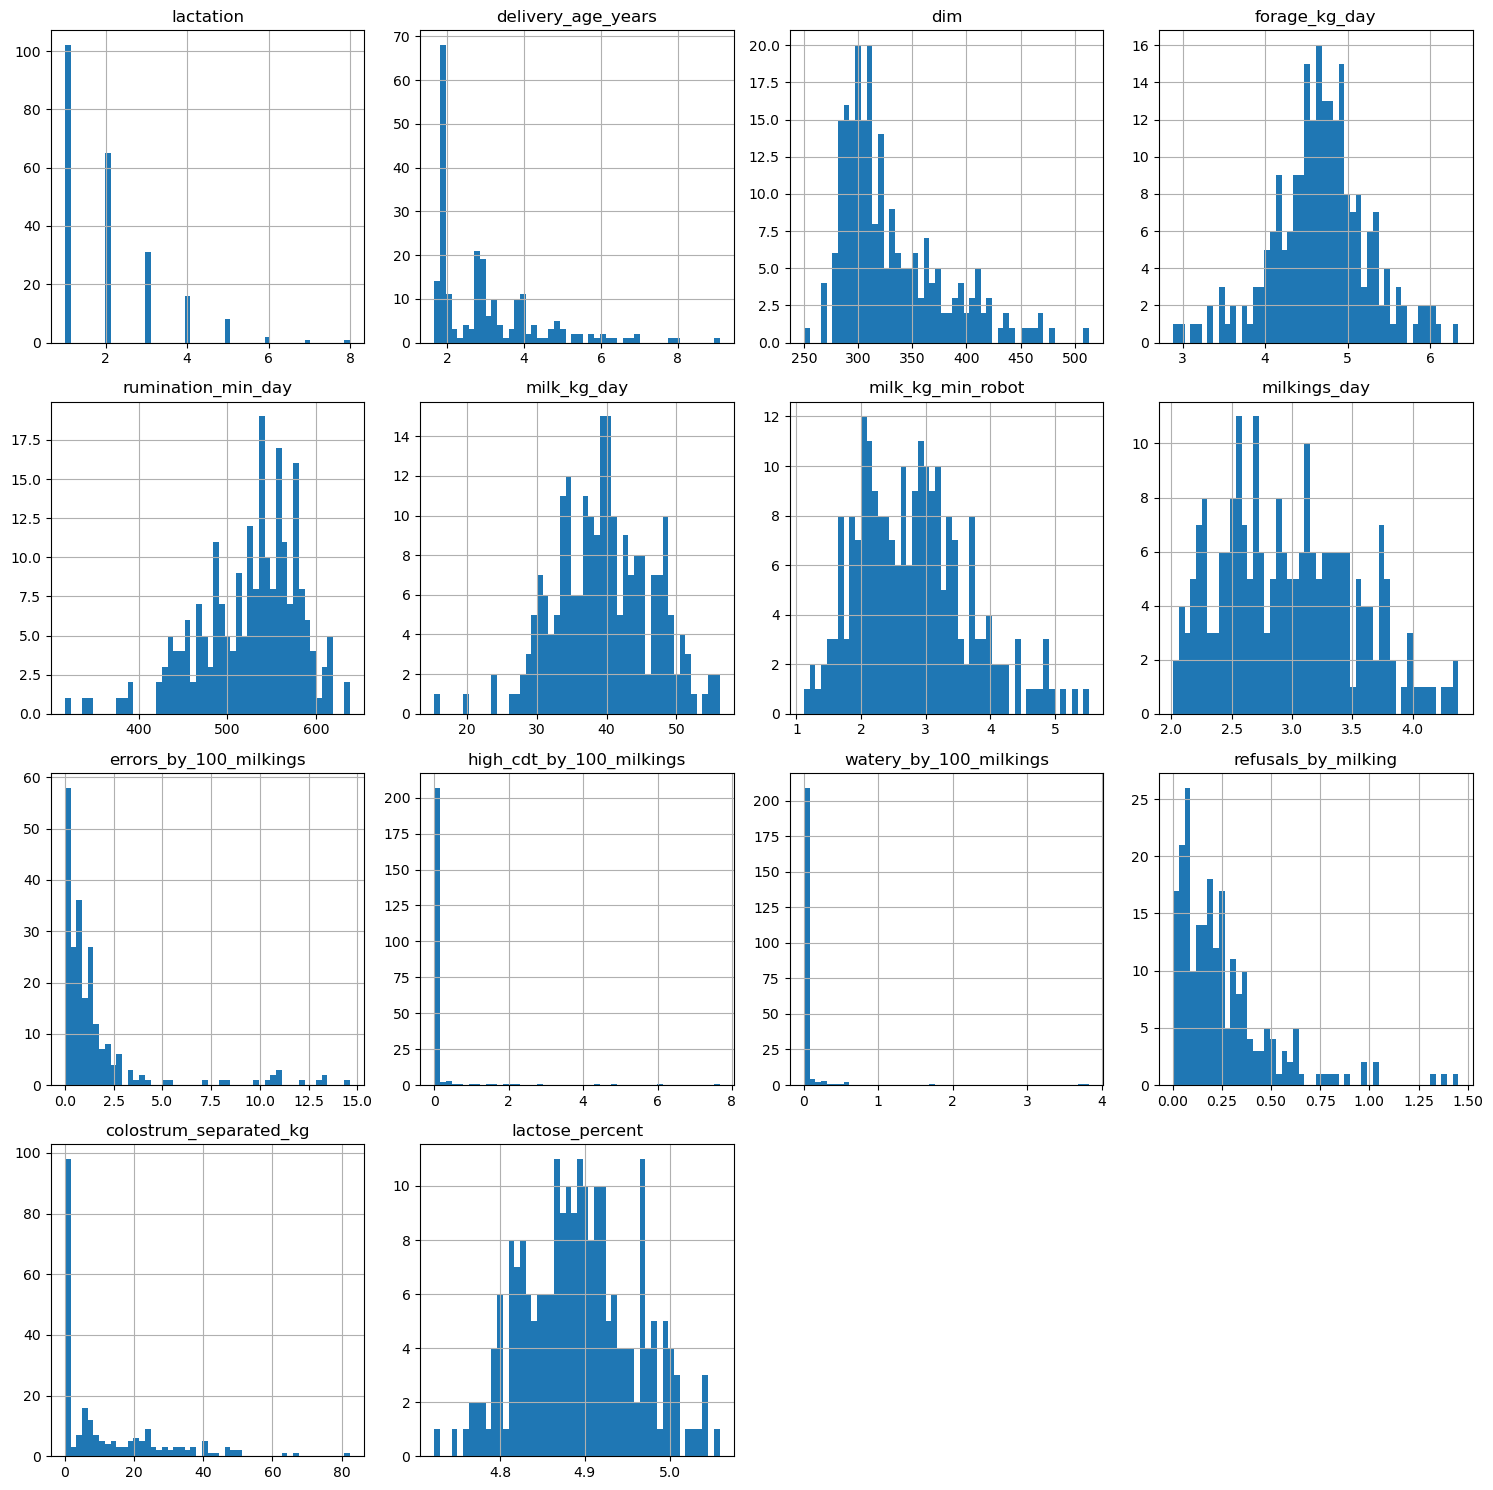

In [6]:
pd.concat([X_train, y_train], axis = 1).hist(figsize=(15, 15), bins=50)
plt.grid(False)
plt.tight_layout()
plt.show()

Our data has outliers and a lot of skewness as we see from distributions. For GP algorithms it is not that crucial to fix it as there are no statistical assumptions such as we have with Linear models. However, it might still help to improve the perfomance. Moreover, we will use simple Neaural Networks, for which it is important and might affect the results. That is why we will fix it later

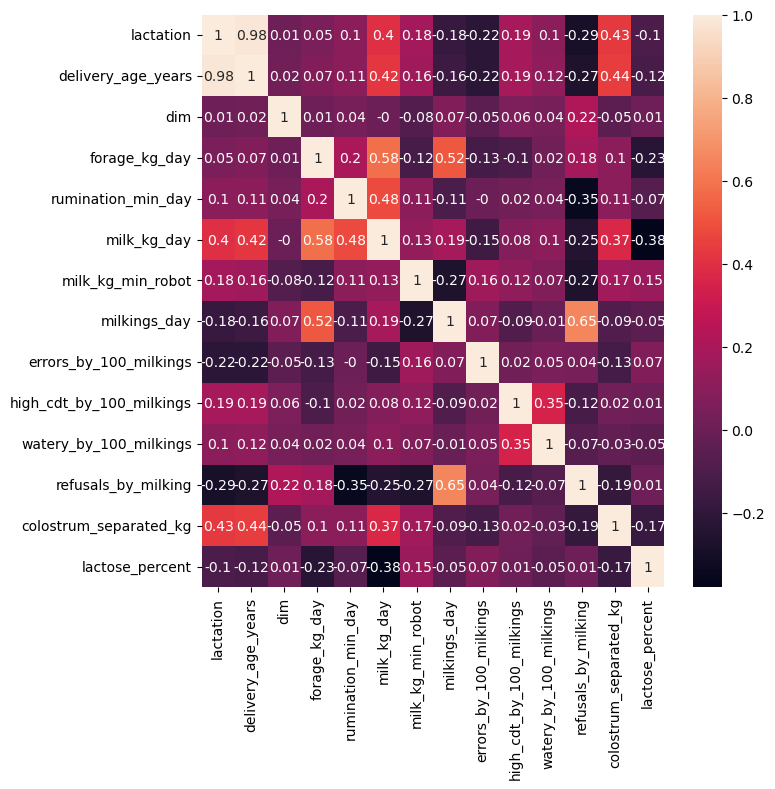

In [7]:
plt.figure(figsize=(8,8))
sns.heatmap(np.round(pd.concat([X_train, y_train], axis = 1).corr(),2), annot=True)
plt.grid(False)
plt.tight_layout()
plt.show()

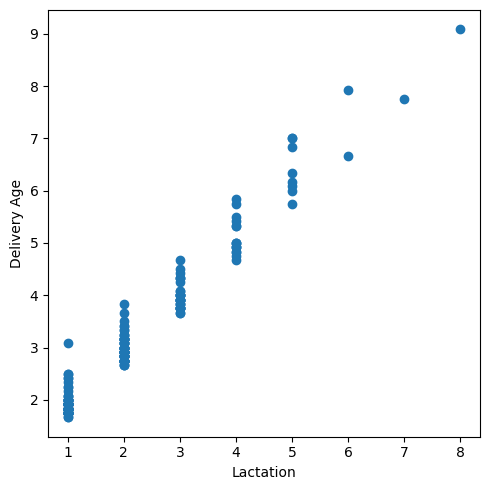

In [8]:
#Explore lactation and delivery_age_years

plt.figure(figsize=(5,5))
plt.scatter(X_train['lactation'], X_train['delivery_age_years'])
plt.xlabel('Lactation')
plt.ylabel('Delivery Age')
plt.grid(False)
plt.tight_layout()
plt.show()

- From the heatmap we see that lactation and delivery_age_years are almost perfectly correleted meaning that we can use one of them. We will remove lactation as it has less variability comapring to delivery_age_years
- There are no other strong correlations in our data
- Strongest correlation with target is -0.36 (still quite small number) for milk_kg_day, meaning that in our data the more milk is produced by cow per day the lower is lactose level. 

In [9]:
X_train = X_train[X_train.columns.drop('lactation')]
X_test = X_test[X_test.columns.drop('lactation')]

In [10]:
# Exploring skewness and possible tranformations

for k in range(len(X_train.columns)):
    i = X_train.columns[k]
    print(i)
    print("Skewness: {}".format(sc.skew(X_train[i])))
    if sc.skew(X_train[i]) > 0:
        print("Skewness after log transform: {}".format(sc.skew(np.log1p(X_train[i]))))
        print("Skewness after sqrt transform: {}".format(sc.skew(np.sqrt(X_train[i]))))
    else:
        print("Skewness after squared transform: {}".format(sc.skew(X_train[i]**2)))
    print('\n')
    # plt.figure(figsize=(5, 3))
    # sns.histplot(X_train[i]**0.5, bins=30, kde=True)
    plt.show()

delivery_age_years
Skewness: 1.52910135388326
Skewness after log transform: 0.8216865358041997
Skewness after sqrt transform: 1.046687981883525


dim
Skewness: 1.2374369256655715
Skewness after log transform: 0.9434998178811719
Skewness after sqrt transform: 1.086444324053219


forage_kg_day
Skewness: -0.15109344297892194
Skewness after squared transform: 0.35905076132881397


rumination_min_day
Skewness: -0.8213768705520379
Skewness after squared transform: -0.47850896394583836


milk_kg_day
Skewness: -0.10690155636048342
Skewness after squared transform: 0.4059469621822242


milk_kg_min_robot
Skewness: 0.5997828824819764
Skewness after log transform: 0.04915101502597984
Skewness after sqrt transform: 0.2205418129881013


milkings_day
Skewness: 0.34912220799976673
Skewness after log transform: 0.1047832495013459
Skewness after sqrt transform: 0.18477050475750253


errors_by_100_milkings
Skewness: 3.0217812012510388
Skewness after log transform: 1.2662934828558587
Skewness after sqrt t

We will apply following transformations to fix positive and negative skewness:

Sqrt
- errors_by_100_milkings
- high_cdt_by_100_milkings
- watery_by_100_milkings
- refusals_by_milking

Log
- delivery_age_years
- dim
- milk_kg_min_robot
- colostrum_separated_kg

Square
- rumination_min_day

In [11]:
for i in ['errors_by_100_milkings', 'high_cdt_by_100_milkings', 'watery_by_100_milkings', 'refusals_by_milking']:
    X_train[i] = np.sqrt(X_train[i])
    X_test[i] = np.sqrt(X_test[i])


for i in ['delivery_age_years', 'dim', 'milk_kg_min_robot', 'colostrum_separated_kg']:
    X_train[i] = np.log1p(X_train[i])
    X_test[i] = np.log1p(X_test[i])


for i in ['rumination_min_day']:
    X_train[i] = X_train[i]**2
    X_test[i] = X_test[i]**2




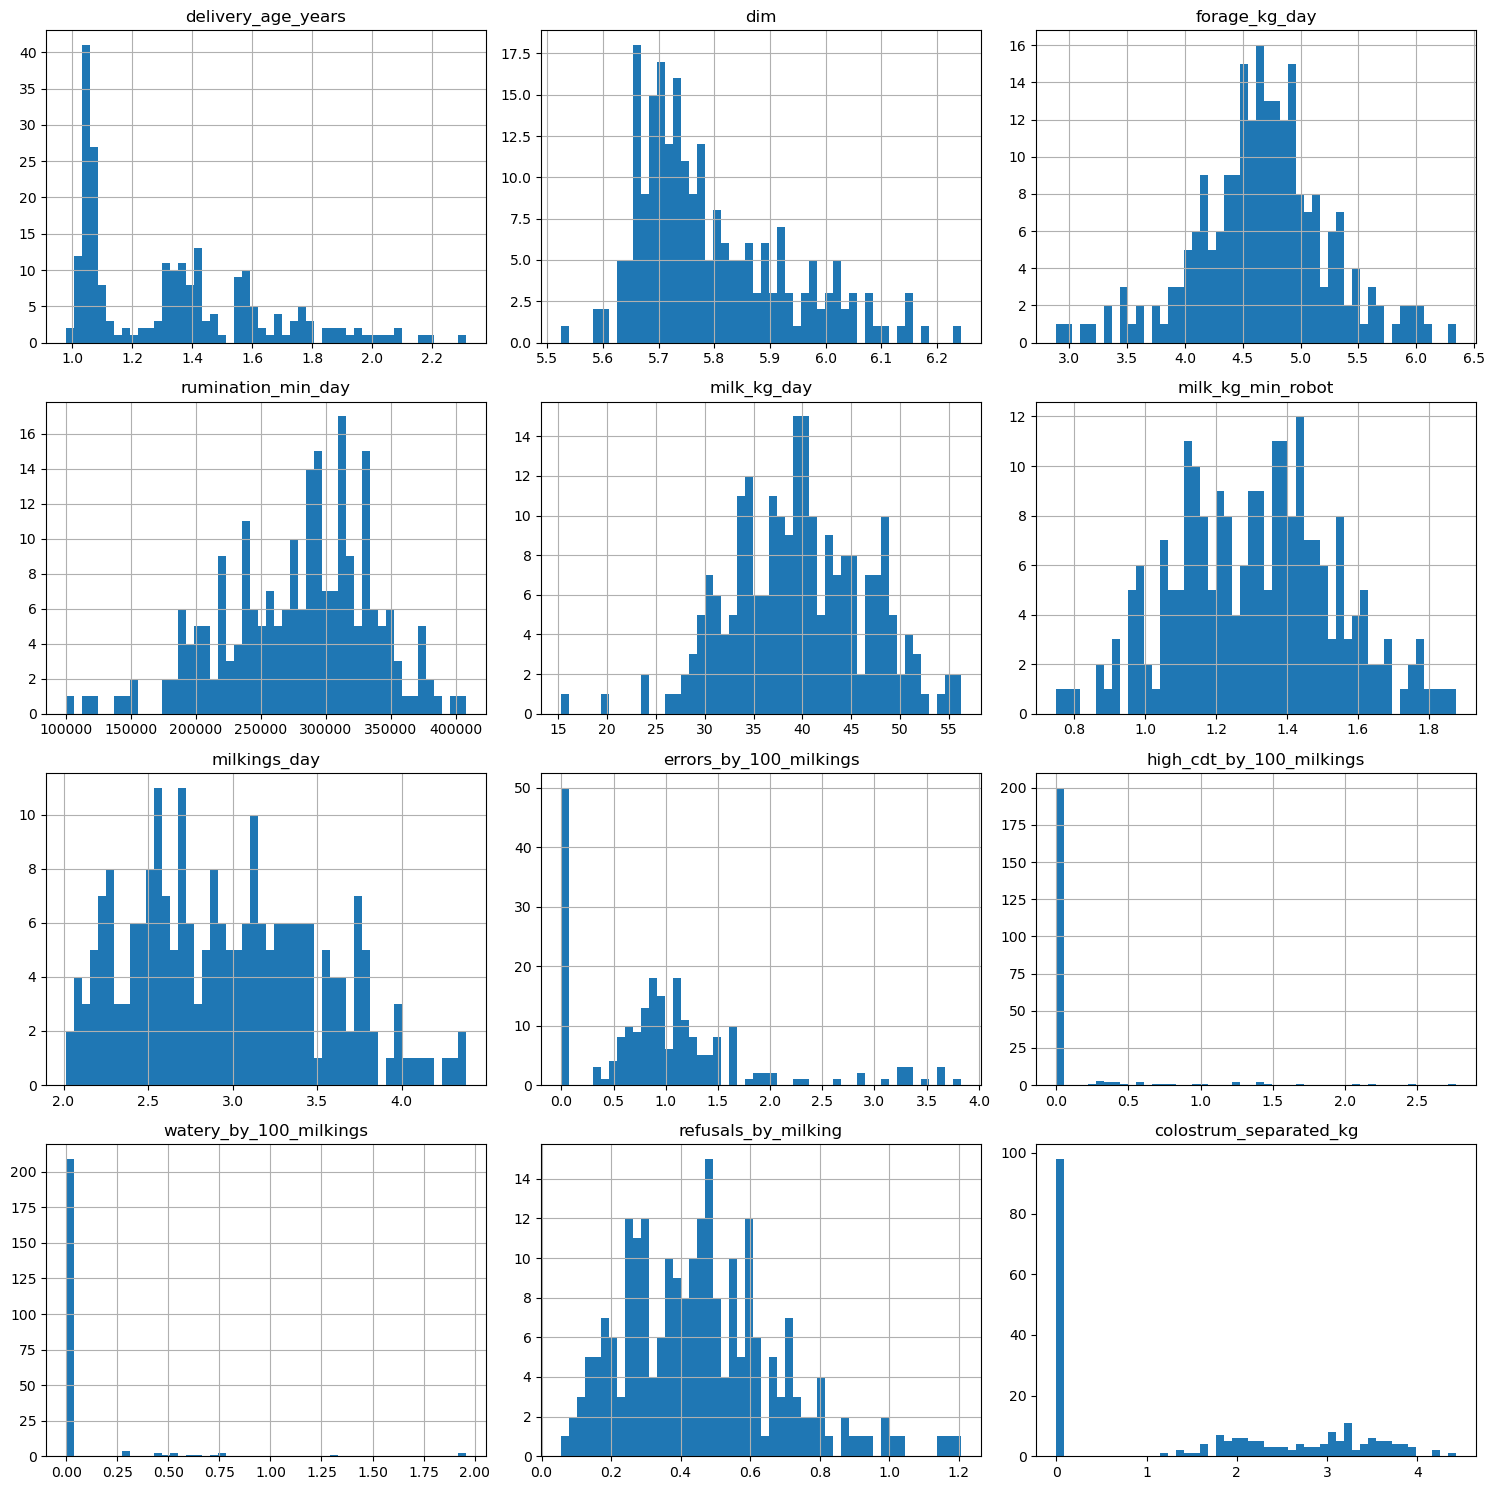

In [12]:
X_train.hist(figsize=(15, 15), bins=50)
plt.grid(False)
plt.tight_layout()
plt.show()

It looks less skewed now and we will try to identify outliers using visual approach, exploring distributions from plots. Replace them with NaN values in train, val, test and then use KNN Imputer fitted with train data to fill these misisng values

In [13]:
X_train.columns

Index(['delivery_age_years', 'dim', 'forage_kg_day', 'rumination_min_day',
       'milk_kg_day', 'milk_kg_min_robot', 'milkings_day',
       'errors_by_100_milkings', 'high_cdt_by_100_milkings',
       'watery_by_100_milkings', 'refusals_by_milking',
       'colostrum_separated_kg'],
      dtype='object')

In [14]:
X_train.loc[X_train['watery_by_100_milkings'] > 1, 'watery_by_100_milkings'] = np.nan
X_train.loc[X_train['high_cdt_by_100_milkings'] > 2, 'high_cdt_by_100_milkings'] = np.nan
X_train.loc[X_train['errors_by_100_milkings'] > 3, 'errors_by_100_milkings'] = np.nan
X_train.loc[X_train['colostrum_separated_kg'] > 4, 'colostrum_separated_kg'] = np.nan
X_train.loc[X_train['milkings_day'] > 4, 'milkings_day'] = np.nan
X_train.loc[X_train['refusals_by_milking'] > 1, 'refusals_by_milking'] = np.nan
X_train.loc[X_train['delivery_age_years'] > 1.8, 'delivery_age_years'] = np.nan
X_train.loc[X_train['dim'] > 6.1, 'dim'] = np.nan
X_train.loc[X_train['dim'] < 5.6, 'dim'] = np.nan
X_train.loc[X_train['forage_kg_day'] > 6, 'forage_kg_day'] = np.nan
X_train.loc[X_train['forage_kg_day'] < 3.5, 'forage_kg_day'] = np.nan
X_train.loc[X_train['rumination_min_day'] > 390000, 'rumination_min_day'] = np.nan
X_train.loc[X_train['rumination_min_day'] < 170000, 'rumination_min_day'] = np.nan
X_train.loc[X_train['milk_kg_day'] < 25, 'milk_kg_day'] = np.nan
X_train.loc[X_train['milk_kg_min_robot'] < 0.9, 'milk_kg_min_robot'] = np.nan
X_train.loc[X_train['milk_kg_min_robot'] > 1.7, 'milk_kg_min_robot'] = np.nan

X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 226 entries, 126 to 168
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   delivery_age_years        208 non-null    float64
 1   dim                       215 non-null    float64
 2   forage_kg_day             213 non-null    float64
 3   rumination_min_day        217 non-null    float64
 4   milk_kg_day               222 non-null    float64
 5   milk_kg_min_robot         210 non-null    float64
 6   milkings_day              218 non-null    float64
 7   errors_by_100_milkings    214 non-null    float64
 8   high_cdt_by_100_milkings  222 non-null    float64
 9   watery_by_100_milkings    223 non-null    float64
 10  refusals_by_milking       221 non-null    float64
 11  colostrum_separated_kg    223 non-null    float64
dtypes: float64(12)
memory usage: 23.0 KB


In [15]:
X_test.loc[X_test['watery_by_100_milkings'] > 1, 'watery_by_100_milkings'] = np.nan
X_test.loc[X_test['high_cdt_by_100_milkings'] > 2, 'high_cdt_by_100_milkings'] = np.nan
X_test.loc[X_test['errors_by_100_milkings'] > 3, 'errors_by_100_milkings'] = np.nan
X_test.loc[X_test['colostrum_separated_kg'] > 4, 'colostrum_separated_kg'] = np.nan
X_test.loc[X_test['milkings_day'] > 4, 'milkings_day'] = np.nan
X_test.loc[X_test['refusals_by_milking'] > 1, 'refusals_by_milking'] = np.nan
X_test.loc[X_test['delivery_age_years'] > 1.8, 'delivery_age_years'] = np.nan
X_test.loc[X_test['dim'] > 6.1, 'dim'] = np.nan
X_test.loc[X_test['dim'] < 5.6, 'dim'] = np.nan
X_test.loc[X_test['forage_kg_day'] > 6, 'forage_kg_day'] = np.nan
X_test.loc[X_test['forage_kg_day'] < 3.5, 'forage_kg_day'] = np.nan
X_test.loc[X_test['rumination_min_day'] > 390000, 'rumination_min_day'] = np.nan
X_test.loc[X_test['rumination_min_day'] < 170000, 'rumination_min_day'] = np.nan
X_test.loc[X_test['milk_kg_day'] < 25, 'milk_kg_day'] = np.nan
X_test.loc[X_test['milk_kg_min_robot'] < 0.9, 'milk_kg_min_robot'] = np.nan
X_test.loc[X_test['milk_kg_min_robot'] > 1.7, 'milk_kg_min_robot'] = np.nan

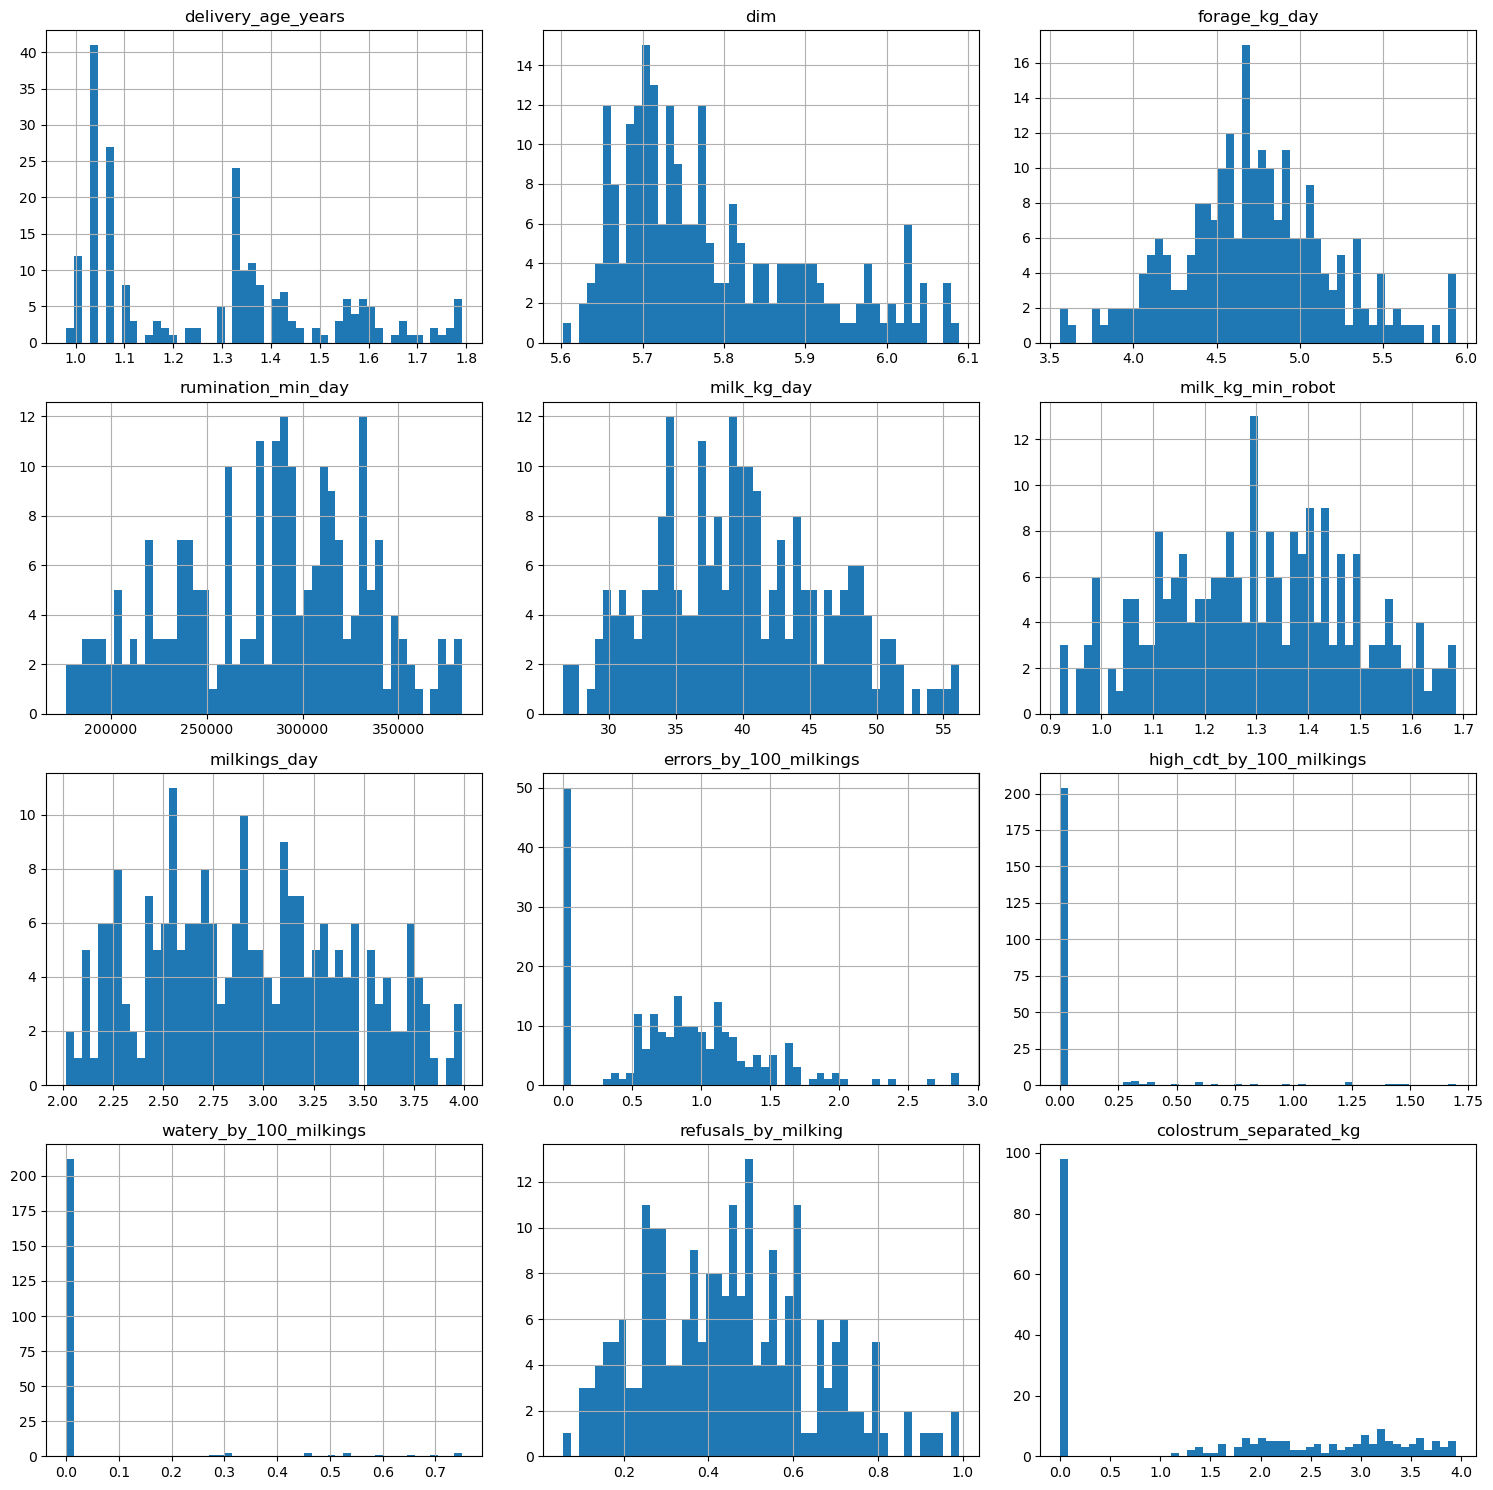

In [16]:
imputer = KNNImputer(n_neighbors=5)  

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)

X_test = pd.DataFrame(imputer.fit_transform(X_test), columns=X_train.columns, index=X_test.index)

X_train.hist(figsize=(15, 15), bins=50)
plt.grid(False)
plt.tight_layout()
plt.show()

## Model tuning

We we will perform cross validation for the modellinf stage, data scaling will be performed inside each fold. All the other preprocessing was done before as it is quite heavy code, but in a real world scenario we should rely only on training data to remove outliers, fix skewness and other issues on both train and test

### GP

In [34]:
seed = 1
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
shuffle = True
total_batches = 1


fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div']]

best_val_fitness = float('inf')
best_params = {}

sspace_sml = {
    'n_dims': X_train.shape[1],
    'function_set': fset, 'constant_set': ERC(-1., 1.),
    'p_constants': 0.1,
    'max_init_depth': 3,
    'max_depth': 10, 
    'n_batches': total_batches,
    'device': device
}
mutations = [hoist_mtn, prm_subtree_mtn(initializer=prm_grow(sspace_sml))]
selectors = [prm_tournament(pressure=0.07), double_tournament(pressure=0.07)]
initializers = [grow]


for mutation  in tqdm(mutations):
    for selector in selectors:
        for init in initializers:
            # Cross-validation
            kf = KFold(n_splits=5, shuffle=True, random_state=42)

            val_losses = []

            for i in tqdm(kf.split(X_train)):
                X_tr, X_val = X_train.iloc[i[0]], X_train.iloc[i[1]]
                y_tr, y_val = y_train.iloc[i[0]], y_train.iloc[i[1]]

                scaler = MinMaxScaler()
                X_tr = scaler.fit_transform(X_tr)
                X_val = scaler.transform(X_val)

                X_tr = torch.tensor(X_tr, dtype=torch.float32)
                X_val = torch.tensor(X_val, dtype=torch.float32)

                y_tr = torch.tensor(y_tr.values, dtype=torch.float32).reshape(1,-1)[0]
                y_val = torch.tensor(y_val.values, dtype=torch.float32).reshape(1,-1)[0]

                ds_train = TensorDataset(X_tr, y_tr)
                ds_val = TensorDataset(X_val, y_val)

                total_batches = 1
                batch_size = X_tr.shape[0]
                shuffle = True

                # Creates training and test data loaders
                dl_train = DataLoader(ds_train, batch_size, shuffle)
                dl_val = DataLoader(ds_val, batch_size, shuffle)

                # algorithm specific part


                fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div']]

                sspace_sml = {
                    'n_dims': X_tr.shape[1],
                    'function_set': fset, 'constant_set': ERC(-1., 1.),
                    'p_constants': 0.1,
                    'max_init_depth': 3,
                    'max_depth': 10, 
                    'n_batches': total_batches,
                    'device': device
                }

                pi_sml = SML(
                    sspace = sspace_sml,
                    ffunction = Ffunctions('rmse'),
                    dl_train = dl_train, dl_test=dl_val, 
                    n_jobs = 1
                )

                ps = 500
                selection_pressure = .07
                mutation_prob = .1
                xo_prob = .9
                has_elitism = True
                allow_reproduction = False

                mheuristic = GeneticAlgorithm(
                    pi=pi_sml,
                    initializer=init,
                    selector=selector,
                    crossover=swap_xo,
                    mutator=mutation,
                    pop_size=ps,
                    p_m=0.1,
                    p_c=0.9,
                    elitism=has_elitism,
                    reproduction=allow_reproduction,  
                    device=device,
                    seed=seed
                )

                mheuristic._initialize()

                n_iter = 15
                mheuristic.solve(
                n_iter,
                # verbose=3,
                test_elite=True
                )

                val_losses.append(mheuristic.best_sol.test_fit)
                
            print(f"Selection type: {selector}, mutation type: {mutation}, initializer: {init}")
            print(f"Average val fitness of best solution: {torch.mean(torch.tensor(val_losses))}")

            if torch.mean(torch.tensor(val_losses)) < best_val_fitness:
                            best_val_fitness = torch.mean(torch.tensor(val_losses))
                            best_params = {
                                'selection type': selector,
                                'mutation type': mutation,
                                'initializer': init
                            }
    

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Selection type: <function prm_tournament.<locals>.tournament at 0x1686d2c00>, mutation type: <function hoist_mtn at 0x164f77a60>, initializer: <function grow at 0x164f84540>
Average val fitness of best solution: 0.06788235157728195


0it [00:00, ?it/s]

Selection type: <function double_tournament.<locals>.second_tournament at 0x1686d3a60>, mutation type: <function hoist_mtn at 0x164f77a60>, initializer: <function grow at 0x164f84540>
Average val fitness of best solution: 2.4499125480651855


0it [00:00, ?it/s]

Selection type: <function prm_tournament.<locals>.tournament at 0x1686d2c00>, mutation type: <function prm_subtree_mtn.<locals>.subtree_mtn at 0x1686d2ac0>, initializer: <function grow at 0x164f84540>
Average val fitness of best solution: 0.07409775257110596


0it [00:00, ?it/s]

Selection type: <function double_tournament.<locals>.second_tournament at 0x1686d3a60>, mutation type: <function prm_subtree_mtn.<locals>.subtree_mtn at 0x1686d2ac0>, initializer: <function grow at 0x164f84540>
Average val fitness of best solution: 2.085111141204834


In [35]:
print(f"Best val fitness: {best_val_fitness}")
print(f"Best parameters: {best_params}")

Best val fitness: 0.06788235157728195
Best parameters: {'selection type': <function prm_tournament.<locals>.tournament at 0x1686d2c00>, 'mutation type': <function hoist_mtn at 0x164f77a60>, 'initializer': <function grow at 0x164f84540>}


### GSGP

In [36]:
seed = 1
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
shuffle = True
total_batches = 1

fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div']]

sspace_sml = {
    'n_dims': X_train.shape[1],
    'function_set': fset, 'constant_set': ERC(-1., 1.),
    'p_constants': 0.1,
    'max_init_depth': 3,
    'max_depth': 10, 
    'n_batches': total_batches,
    'device': device
}
selectors = [prm_tournament(pressure=0.07), roulette_wheel, double_tournament(pressure=0.07)]
initializers = [grow]

best_val_fitness = float('inf')
best_params = {}

for selector in tqdm(selectors):
    for init in initializers:
        # Cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        val_losses = []

        for i in tqdm(kf.split(X_train)):
            X_tr, X_val = X_train.iloc[i[0]], X_train.iloc[i[1]]
            y_tr, y_val = y_train.iloc[i[0]], y_train.iloc[i[1]]

            scaler = MinMaxScaler()
            X_tr = scaler.fit_transform(X_tr)
            X_val = scaler.transform(X_val)

            X_tr = torch.tensor(X_tr, dtype=torch.float32)
            X_val = torch.tensor(X_val, dtype=torch.float32)

            y_tr= torch.tensor(y_tr.values, dtype=torch.float32).reshape(1,-1)[0]
            y_val = torch.tensor(y_val.values, dtype=torch.float32).reshape(1,-1)[0]

            ds_train = TensorDataset(X_tr, y_tr)
            ds_val = TensorDataset(X_val, y_val)

            total_batches = 1
            batch_size = X_tr.shape[0]
            shuffle = True

            # Creates training and test data loaders
            dl_train = DataLoader(ds_train, batch_size, shuffle)
            dl_val = DataLoader(ds_val, batch_size, shuffle)

            # algorithm specific part


            fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div']]

            sspace_sml = {
                'n_dims': X_tr.shape[1],
                'function_set': fset, 'constant_set': ERC(-1., 1.),
                'p_constants': 0.1,
                'max_init_depth': 3,
                'max_depth': 10, 
                'n_batches': total_batches,
                'device': device
            }

            pi_sml = SML(
                sspace=sspace_sml,
                ffunction=Ffunctions('rmse'),
                dl_train=dl_train, dl_test=dl_val,  # For the algorithm, the unseen is our validation!
                n_jobs=1
            )

            ps = 250
            selection_pressure = .01
            mutation_prob = .1
            xo_prob = .9
            has_elitism = True
            allow_reproduction = False

            to, by = 5.0, 0.25
            ms = torch.arange(by, to + by, by, device=device)

            mheuristic = GeneticAlgorithm(
                pi=pi_sml,
                initializer=init,
                selector=selector,
                pop_size=ps,
                p_m=mutation_prob,
                p_c=xo_prob,
                elitism=has_elitism,
                reproduction=allow_reproduction,  # False = or xo or mutation
                device=device,
                seed=seed,
                crossover=prm_gs_xo(prm_grow(sspace=pi_sml.sspace), device=device),
                mutator=prm_gs_mtn(prm_grow(sspace=pi_sml.sspace), ms))

            mheuristic._initialize()

            n_iter = 5
            mheuristic.solve(
            n_iter,
            # verbose=3,
            test_elite=True
            )

            val_losses.append(mheuristic.best_sol.test_fit)
            
        print(f"Selection type: {selector}, initializer: {init}")
        print(f"Average val fitness of best solution: {torch.mean(torch.tensor(val_losses))}")

        if torch.mean(torch.tensor(val_losses)) < best_val_fitness:
                        best_val_fitness = torch.mean(torch.tensor(val_losses))
                        best_params = {
                            'selection type': selector,
                            'mutation type': mutation,
                            'initializer': init
                        }
    

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Selection type: <function prm_tournament.<locals>.tournament at 0x169f75c60>, initializer: <function grow at 0x164f84540>
Average val fitness of best solution: 0.7670334577560425


0it [00:00, ?it/s]

Selection type: <function roulette_wheel at 0x164f774c0>, initializer: <function grow at 0x164f84540>
Average val fitness of best solution: 0.7870678901672363


0it [00:00, ?it/s]

Selection type: <function double_tournament.<locals>.second_tournament at 0x169f75620>, initializer: <function grow at 0x164f84540>
Average val fitness of best solution: 0.5558097958564758


In [37]:
print(f"Best val fitness: {best_val_fitness}")
print(f"Best parameters: {best_params}")

Best val fitness: 0.5558097958564758
Best parameters: {'selection type': <function double_tournament.<locals>.second_tournament at 0x169f75620>, 'mutation type': <function prm_subtree_mtn.<locals>.subtree_mtn at 0x1686d2ac0>, 'initializer': <function grow at 0x164f84540>}


### Simple ML

In [31]:
n_estimators = [10, 50, 100, 200]
max_depth = [2, 5, 10, 20]

best_score = float('inf')
best_params = {}

for n_est in tqdm(n_estimators):
    for max_d in max_depth:
        # Cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        all_val_losses = []

        for i in kf.split(X_train):
            X_tr, X_val = X_train.iloc[i[0]], X_train.iloc[i[1]]
            y_tr, y_val = y_train.iloc[i[0]].values.reshape(-1), y_train.iloc[i[1]].values.reshape(-1)

            scaler = MinMaxScaler()
            X_tr = scaler.fit_transform(X_tr)
            X_val = scaler.transform(X_val)

            rf = RandomForestRegressor(n_estimators=n_est, max_depth=max_d, random_state=0)
            rf.fit(X_tr, y_tr)
            all_val_losses.append(mean_squared_error(y_val, rf.predict(X_val))**0.5)
        if np.mean(all_val_losses) < best_score:
            best_score = np.mean(all_val_losses)
            best_params = {'n_estimators': n_est,'max_depth': max_d}
        print(f"N estimators: {n_est}, Max depth: {max_d},  Avg val score: {np.mean(all_val_losses)}")


print(f"Best params: {best_params}")
print(f"Best score: {best_score}")

  0%|          | 0/4 [00:00<?, ?it/s]

N estimators: 10, Max depth: 2,  Avg val score: 0.06399923220924833
N estimators: 10, Max depth: 5,  Avg val score: 0.06523493755180829
N estimators: 10, Max depth: 10,  Avg val score: 0.06741686646477982
N estimators: 10, Max depth: 20,  Avg val score: 0.06705133334112184
N estimators: 50, Max depth: 2,  Avg val score: 0.06286177430769206
N estimators: 50, Max depth: 5,  Avg val score: 0.06376086407804096
N estimators: 50, Max depth: 10,  Avg val score: 0.06429848034883737
N estimators: 50, Max depth: 20,  Avg val score: 0.06448940439148403
N estimators: 100, Max depth: 2,  Avg val score: 0.06283864829021538
N estimators: 100, Max depth: 5,  Avg val score: 0.06368552705081218
N estimators: 100, Max depth: 10,  Avg val score: 0.06403731976851242
N estimators: 100, Max depth: 20,  Avg val score: 0.06437921641041906
N estimators: 200, Max depth: 2,  Avg val score: 0.06274387264641187
N estimators: 200, Max depth: 5,  Avg val score: 0.06351351577176542
N estimators: 200, Max depth: 10,  A

In [32]:
# Linreg

kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_val_losses = []

for i in kf.split(X_train):
    X_tr, X_val = X_train.iloc[i[0]], X_train.iloc[i[1]]
    y_tr, y_val = y_train.iloc[i[0]].values.reshape(-1), y_train.iloc[i[1]].values.reshape(-1)

    scaler = MinMaxScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_val = scaler.transform(X_val)

    lr = LinearRegression()
    lr.fit(X_tr, y_tr)
    all_val_losses.append(mean_squared_error(y_val, lr.predict(X_val))**0.5)

print(f"Linreg RMSE: {np.mean(all_val_losses)}")

Linreg RMSE: 0.0620136367113124


### NN

#### NN with Backprop

In [34]:
# We will use simple NN with two hidden layers

class DenseNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DenseNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
        self.apply(self._init_weights)
        

    def _init_weights(self, attribute):
        if isinstance(attribute, nn.Linear):
          torch.nn.init.xavier_uniform_(attribute.weight)
          torch.nn.init.zeros_(attribute.bias)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)

        return out
def get_optimizer(optimizer_name, model_params, lr):
    if optimizer_name == 'Adam':
        return optim.Adam(model_params, lr=lr)
    elif optimizer_name == 'SGD':
        return optim.SGD(model_params, lr=lr, momentum=0.9)
    elif optimizer_name == 'RMSprop':
        return optim.RMSprop(model_params, lr=lr, momentum=0.9)

In [49]:
# Hyperparameters we will not change
input_size = 12
output_size = 1
num_epochs = 100

# Define grid
hidden_sizes = [2, 4, 8, 16, 32]
learning_rates = [0.001, 0.005, 0.01, 0.1]
optimizers = ['Adam', 'SGD', 'RMSprop']

# Variables to store results
best_val_rmse = float('inf')
best_params = {}

for hidden_size in tqdm(hidden_sizes):
    for learning_rate in learning_rates:
        for optimizer_name in optimizers:

            # Cross-validation
            kf = KFold(n_splits=5, shuffle=True, random_state=42)

            all_val_losses = []

            for i in kf.split(X_train):
                X_tr, X_val = X_train.iloc[i[0]], X_train.iloc[i[1]]
                y_tr, y_val = y_train.iloc[i[0]], y_train.iloc[i[1]]

                scaler = MinMaxScaler()
                X_tr = scaler.fit_transform(X_tr)
                X_val = scaler.transform(X_val)

                X_tr = torch.tensor(X_tr, dtype=torch.float32)
                X_val = torch.tensor(X_val, dtype=torch.float32)

                y_tr= torch.tensor(y_tr.values, dtype=torch.float32).reshape(1,-1)[0]
                y_val = torch.tensor(y_val.values, dtype=torch.float32).reshape(1,-1)[0]

                ds_train = TensorDataset(X_tr, y_tr)
                ds_val = TensorDataset(X_val, y_val)

                total_batches = 1
                batch_size = X_tr.shape[0]
                shuffle = True

                # Creates training and test data loaders
                dl_train = DataLoader(ds_train, batch_size, shuffle)
                dl_val = DataLoader(ds_val, batch_size, shuffle)

                # algorithm specific part

                model = DenseNN(input_size, hidden_size, output_size)
                criterion = nn.MSELoss()
                optimizer = get_optimizer(optimizer_name, model.parameters(), learning_rate)

                # Lists to store RMSE for each epoch on train and val
                train_rmse_list = []
                val_rmse_list = []


                # Training 
                for epoch in range(num_epochs):
                    model.train()
                    train_losses = []
                    for inputs, targets in dl_train:
                        outputs = model(inputs)
                        loss = criterion(outputs.squeeze(1), targets)
                        train_losses.append(loss.item())
                        

                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                    
                    # Recalculate MSE to RMSE
                    # Mean in case of 
                    avg_train_rmse = np.sqrt(np.mean(train_losses))
                    train_rmse_list.append(avg_train_rmse)

                    # Val evaluation
                    model.eval()
                    with torch.no_grad():
                        val_losses = []
                        for val_inputs, val_targets in dl_val:
                            val_outputs = model(val_inputs)
                            val_loss = criterion(val_outputs.squeeze(1), val_targets)
                            val_losses.append(val_loss.item())
                        avg_val_loss = np.mean(val_losses)
                        
                    # Recalculate MSE to RMSE
                    avg_val_rmse = np.sqrt(np.mean(val_losses))
                    val_rmse_list.append(avg_val_rmse)

                all_val_losses.append(avg_val_rmse)
            
            print(f'Hidden Size: {hidden_size}, Learning Rate: {learning_rate}, Optimizer: {optimizer_name}')
            print(f'Average Val RMSE: {torch.mean(torch.tensor(all_val_losses))}')

            if torch.mean(torch.tensor(all_val_losses)) < best_val_rmse:
                            best_val_rmse = torch.mean(torch.tensor(all_val_losses))
                            best_params = {
                                'hidden_size': hidden_size,
                                'learning_rate': learning_rate,
                                'optimizer': optimizer_name,
                                'train_rmse_list': train_rmse_list,
                                'val_rmse_list': val_rmse_list
                            }

  0%|          | 0/5 [00:00<?, ?it/s]

Hidden Size: 2, Learning Rate: 0.001, Optimizer: Adam
Average Val RMSE: 4.283883756928275
Hidden Size: 2, Learning Rate: 0.001, Optimizer: SGD
Average Val RMSE: 0.48511319264660324
Hidden Size: 2, Learning Rate: 0.001, Optimizer: RMSprop
Average Val RMSE: 1.6253517934482307
Hidden Size: 2, Learning Rate: 0.005, Optimizer: Adam
Average Val RMSE: 2.1545259184703527
Hidden Size: 2, Learning Rate: 0.005, Optimizer: SGD
Average Val RMSE: 0.11883116241070849
Hidden Size: 2, Learning Rate: 0.005, Optimizer: RMSprop
Average Val RMSE: 0.30493851909792247
Hidden Size: 2, Learning Rate: 0.01, Optimizer: Adam
Average Val RMSE: 3.2929649367742835
Hidden Size: 2, Learning Rate: 0.01, Optimizer: SGD
Average Val RMSE: 0.07257792250028161
Hidden Size: 2, Learning Rate: 0.01, Optimizer: RMSprop
Average Val RMSE: 0.10725222265906584
Hidden Size: 2, Learning Rate: 0.1, Optimizer: Adam
Average Val RMSE: 0.16524274204565764
Hidden Size: 2, Learning Rate: 0.1, Optimizer: SGD
Average Val RMSE: 0.0666517504494

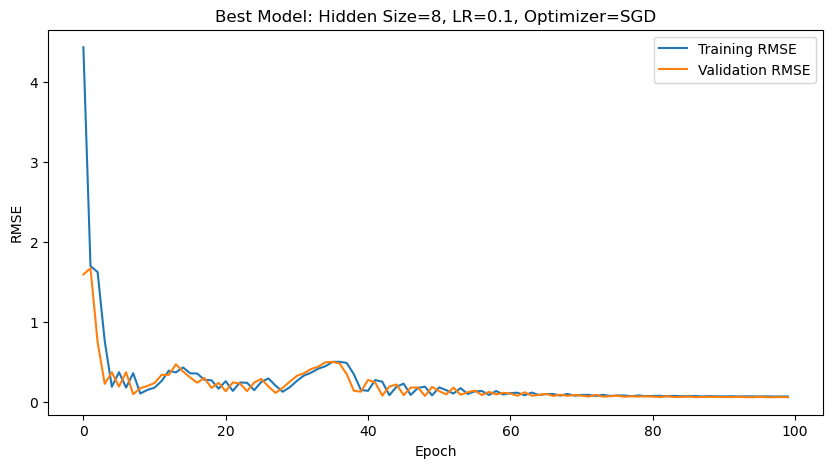

Best Validation RMSE: 0.0651
Best Parameters: {'hidden_size': 8, 'learning_rate': 0.1, 'optimizer': 'SGD', 'train_rmse_list': [4.430168004692902, 1.6948329405476388, 1.620144780011982, 0.7570396887404363, 0.1871393231533506, 0.3684587791516672, 0.17660871297615532, 0.3559161504181875, 0.10173955028619064, 0.1476302785083144, 0.17541752377464528, 0.2590754813334378, 0.38642934123210115, 0.3657187040189277, 0.4281268996871791, 0.3545600889135049, 0.35164030061921686, 0.2725443421823332, 0.2678231836544914, 0.16192988719845972, 0.2559039681282004, 0.13465815557475838, 0.23970811469244196, 0.2361290936930514, 0.14342537070291775, 0.24710235086420387, 0.29038278525512273, 0.20128341471445702, 0.12388352890514774, 0.18012348439533982, 0.2595246423365895, 0.3269895253034921, 0.3622502494281992, 0.4125078634032779, 0.44269936122404435, 0.4975228638403154, 0.4983398473381926, 0.4842581146478076, 0.34401874440711583, 0.14566166315944, 0.13551115367835698, 0.26996051771186225, 0.2493029652434092,

In [51]:
# Plotting RMSE for last block of CV in best model
plt.figure(figsize=(10, 5))
plt.plot(best_params['train_rmse_list'], label='Training RMSE')
plt.plot(best_params['val_rmse_list'], label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title(f'Best Model: Hidden Size={best_params["hidden_size"]}, LR={best_params["learning_rate"]}, Optimizer={best_params["optimizer"]}')
plt.legend()
plt.show()


print(f'Best Validation RMSE: {best_val_rmse:.4f}')
print(f'Best Parameters: {best_params}')

#### NN with Neuroevolution

In [36]:
best_val_fitness = float('inf')
best_params = {}

n_hidden_list = [[4,4], [8,8], [16,16], [32,32]]
ms_list = [ 0.1, 0.2]
probs = [(0.1,0.1), (0.1,0.9), (0.9,0.1), (0.5,0.5)]

for n_hidden in tqdm(n_hidden_list):
    for ms in ms_list:
        for prob in probs:

            # Cross-validation
            kf = KFold(n_splits=5, shuffle=True, random_state=42)

            val_losses = []

            for i in kf.split(X_train):
                X_tr, X_val = X_train.iloc[i[0]], X_train.iloc[i[1]]
                y_tr, y_val = y_train.iloc[i[0]], y_train.iloc[i[1]]

                scaler = MinMaxScaler()
                X_tr = scaler.fit_transform(X_tr)
                X_val = scaler.transform(X_val)

                X_tr = torch.tensor(X_tr, dtype=torch.float32)
                X_val = torch.tensor(X_val, dtype=torch.float32)

                y_tr= torch.tensor(y_tr.values, dtype=torch.float32).reshape(1,-1)[0]
                y_val = torch.tensor(y_val.values, dtype=torch.float32).reshape(1,-1)[0]

                ds_train = TensorDataset(X_tr, y_tr)
                ds_val = TensorDataset(X_val, y_val)

                total_batches = 1
                batch_size = X_tr.shape[0]
                shuffle = True

                # Creates training and test data loaders
                dl_train = DataLoader(ds_train, batch_size, shuffle)
                dl_val = DataLoader(ds_val, batch_size, shuffle)

                # algorithm specific part

                mutation_prob, xo_prob = prob

                ps = 200
                selection_pressure = .07
                has_elitism = True
                allow_reproduction = False

                sspace_nn = {
                        'input_shape': X_tr.shape[1],
                        'init_factor': .01,
                        'n_hidden_neurons': n_hidden,
                        'activation': [torch.relu, torch.relu, None],
                        'n_output': 1,
                        'n_batches': total_batches,
                        'device': device
                    }

                pi_sml = SMLNN(
                    sspace=sspace_nn,
                    ffunction=Ffunctions('rmse'),
                    dl_train=dl_train, dl_test=dl_val, 
                    n_jobs=8
                )

                mheuristic = GeneticAlgorithm(
                    pi=pi_sml,
                    initializer=nn_init,
                    selector=prm_tournament(pressure=selection_pressure),
                    pop_size=ps,
                    p_m=mutation_prob,
                    p_c=xo_prob,
                    elitism=has_elitism,
                    reproduction=allow_reproduction, 
                    device=device,
                    seed=seed,
                    crossover=nn_xo,
                    mutator=prm_nn_mtn(ms=ms, sspace=sspace_nn)
                )

                mheuristic._initialize()

                n_iter = 25
                mheuristic.solve(
                    n_iter,
                    # verbose=3, 
                    test_elite=True
                )
                
                val_losses.append(mheuristic.best_sol.test_fit)

            print(f"N hidden neurons: {n_hidden}, mutation step: {ms}, mutation probability: {mutation_prob}, crossover probability: {xo_prob}")
            print(f"Average val fitness of best solution: {torch.mean(torch.tensor(val_losses))}")

            if torch.mean(torch.tensor(val_losses)) < best_val_fitness:
                            best_val_fitness = torch.mean(torch.tensor(val_losses))
                            best_params = {
                                'n_hidden': n_hidden,
                                'ms': ms,
                                'mutation_prob': mutation_prob,
                                'xo_prob': xo_prob
                            }


  0%|          | 0/4 [00:00<?, ?it/s]

N hidden neurons: [4, 4], mutation step: 0.1, mutation probability: 0.1, crossover probability: 0.1
Average val fitness of best solution: 0.0651080310344696
N hidden neurons: [4, 4], mutation step: 0.1, mutation probability: 0.1, crossover probability: 0.9
Average val fitness of best solution: 0.06198767572641373
N hidden neurons: [4, 4], mutation step: 0.1, mutation probability: 0.9, crossover probability: 0.1
Average val fitness of best solution: 0.0651080310344696
N hidden neurons: [4, 4], mutation step: 0.1, mutation probability: 0.5, crossover probability: 0.5
Average val fitness of best solution: 0.06287460029125214
N hidden neurons: [4, 4], mutation step: 0.2, mutation probability: 0.1, crossover probability: 0.1
Average val fitness of best solution: 0.0657104104757309
N hidden neurons: [4, 4], mutation step: 0.2, mutation probability: 0.1, crossover probability: 0.9
Average val fitness of best solution: 0.064289391040802
N hidden neurons: [4, 4], mutation step: 0.2, mutation pr

In [37]:
print(f"Best val fitness: {best_val_fitness}")
print(f"Best parameters: {best_params}")

Best val fitness: 0.06089290231466293
Best parameters: {'n_hidden': [16, 16], 'ms': 0.1, 'mutation_prob': 0.1, 'xo_prob': 0.9}


### NEAT

In [38]:
def eval_rmse(net, X, y):
    '''
    Auxiliary funciton to evaluate the RMSE.
    '''
    fit = 0.
    for xi, xo in zip(X, y):
        output = net.activate(xi)
        fit += (output[0] - xo)**2
    # RMSE
    # print((fit/y.shape[0])**.5)
    return float((fit/y.shape[0])**.5)


def eval_genomes(genomes, config):
    '''
    The function used by NEAT-Python to evaluate the fitness of the genomes.
    -> It has to have the two first arguments equals to the genomes and config objects.
    -> It has to update the `fitness` attribute of the genome.
    '''
    for genome_id, genome in genomes:
        # Define the network
        net = neat.nn.FeedForwardNetwork.create(genome, config)

        # Train fitness

        # Calculate as negative as we inverted problem to maximization for NEAT to work
        # It doesn't work with minimization for some reason
        genome.fitness = -eval_rmse(net, X_tr, y_tr)

        # Validation fitness
        genome.fitness_val = -eval_rmse(net, X_val, y_val)
        

In [39]:

config_file = 'config-feedforward-xor-init-hidden-0'
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_file)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

val_losses = []

for i in tqdm(kf.split(X_train)):
    X_tr, X_val = X_train.iloc[i[0]], X_train.iloc[i[1]]
    y_tr, y_val = y_train.iloc[i[0]], y_train.iloc[i[1]]

    scaler = MinMaxScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_val = scaler.transform(X_val)

    X_tr = torch.tensor(X_tr, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)

    y_tr= torch.tensor(y_tr.values, dtype=torch.float32).reshape(1,-1)[0]
    y_val = torch.tensor(y_val.values, dtype=torch.float32).reshape(1,-1)[0]

    ds_train = TensorDataset(X_tr, y_tr)
    ds_val = TensorDataset(X_val, y_val)

    total_batches = 1
    batch_size = X_tr.shape[0]
    shuffle = True

    # Creates training and test data loaders
    dl_train = DataLoader(ds_train, batch_size, shuffle)
    dl_val = DataLoader(ds_val, batch_size, shuffle)

    # algorithm specific part

    p = neat.Population(config)
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)

    winner = p.run(eval_genomes, 15)

    

    val_losses.append(-winner.fitness)

print(f"Average val fitness of best solution: {torch.mean(torch.tensor(val_losses))}")


0it [00:00, ?it/s]


 ****** Running generation 0 ****** 

Population's average fitness: -4.88928 stdev: 0.00000
Best fitness: -4.88928 - size: (1, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 2.291, standard deviation 1.173
Population of 100 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    31     -4.9    0.000     0
     2    0    58     -4.9    0.000     0
     3    0    11       --       --     0
Total extinctions: 0
Generation time: 0.292 sec

 ****** Running generation 1 ****** 

Population's average fitness: -4.74668 stdev: 0.43355
Best fitness: -2.42111 - size: (1, 1) - species 2 - id 149
Average adjusted fitness: 0.045
Mean genetic distance 3.041, standard deviation 1.224
Population of 101 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    20     -4.8    0.001     0
     2    1    56     -2.4    0.091     0
     3    1    25   

RMSE of last validation fold: [0.11940521746873856, 0.10718163102865219]


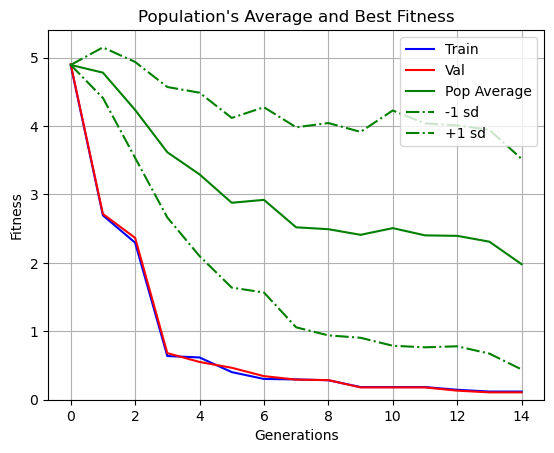

In [40]:
print('RMSE of last validation fold: {}'.format([-winner.fitness, -winner.fitness_val]))

visualize.plot_stats(stats, ylog=False, show_pop=True,  view=True, filename= None)

In [41]:

config_file = 'config-feedforward-xor-init-hidden-2'
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_file)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

val_losses = []

for i in tqdm(kf.split(X_train)):
    X_tr, X_val = X_train.iloc[i[0]], X_train.iloc[i[1]]
    y_tr, y_val = y_train.iloc[i[0]], y_train.iloc[i[1]]

    scaler = MinMaxScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_val = scaler.transform(X_val)

    X_tr = torch.tensor(X_tr, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)

    y_tr= torch.tensor(y_tr.values, dtype=torch.float32).reshape(1,-1)[0]
    y_val = torch.tensor(y_val.values, dtype=torch.float32).reshape(1,-1)[0]

    ds_train = TensorDataset(X_tr, y_tr)
    ds_val = TensorDataset(X_val, y_val)

    total_batches = 1
    batch_size = X_tr.shape[0]
    shuffle = True

    # Creates training and test data loaders
    dl_train = DataLoader(ds_train, batch_size, shuffle)
    dl_val = DataLoader(ds_val, batch_size, shuffle)

    # algorithm specific part

    p = neat.Population(config)
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)

    winner = p.run(eval_genomes, 15)

    

    val_losses.append(-winner.fitness)

print(f"Average val fitness of best solution: {torch.mean(torch.tensor(val_losses))}")


0it [00:00, ?it/s]


 ****** Running generation 0 ****** 

Population's average fitness: -4.88928 stdev: 0.00000
Best fitness: -4.88928 - size: (1, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 2.546, standard deviation 1.235
Population of 100 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    50     -4.9    0.000     0
     2    0    30     -4.9    0.000     0
     3    0    20       --       --     0
Total extinctions: 0
Generation time: 0.278 sec

 ****** Running generation 1 ****** 

Population's average fitness: -4.75500 stdev: 0.38248
Best fitness: -2.25550 - size: (1, 1) - species 2 - id 192
Average adjusted fitness: 0.060
Mean genetic distance 2.963, standard deviation 1.142
Population of 100 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    23     -4.0    0.009     0
     2    1    43     -2.3    0.120     0
     3    1    29   

RMSE of last validation fold: [0.08262041956186295, 0.08493802696466446]


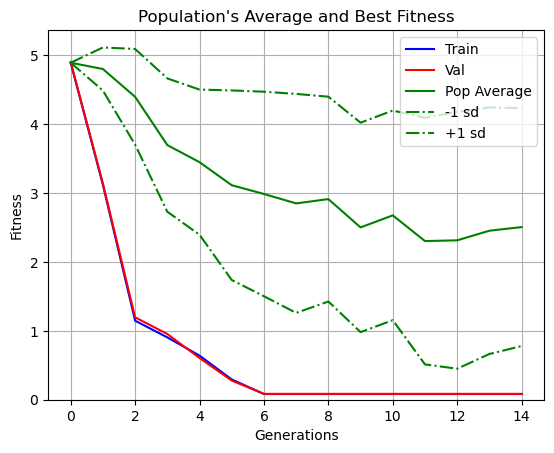

In [42]:
print('RMSE of last validation fold: {}'.format([-winner.fitness, -winner.fitness_val]))

visualize.plot_stats(stats, ylog=False, show_pop=True,  view=True, filename= None)

In [43]:
config_file = 'config-feedforward-xor-full-direct'
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_file)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

val_losses = []

for i in tqdm(kf.split(X_train)):
    X_tr, X_val = X_train.iloc[i[0]], X_train.iloc[i[1]]
    y_tr, y_val = y_train.iloc[i[0]], y_train.iloc[i[1]]

    scaler = MinMaxScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_val = scaler.transform(X_val)

    X_tr = torch.tensor(X_tr, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)

    y_tr= torch.tensor(y_tr.values, dtype=torch.float32).reshape(1,-1)[0]
    y_val = torch.tensor(y_val.values, dtype=torch.float32).reshape(1,-1)[0]

    ds_train = TensorDataset(X_tr, y_tr)
    ds_val = TensorDataset(X_val, y_val)

    total_batches = 1
    batch_size = X_tr.shape[0]
    shuffle = True

    # Creates training and test data loaders
    dl_train = DataLoader(ds_train, batch_size, shuffle)
    dl_val = DataLoader(ds_val, batch_size, shuffle)

    # algorithm specific part

    p = neat.Population(config)
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)

    winner = p.run(eval_genomes, 15)

    

    val_losses.append(-winner.fitness)

print(f"Average val fitness of best solution: {torch.mean(torch.tensor(val_losses))}")


0it [00:00, ?it/s]


 ****** Running generation 0 ****** 

Population's average fitness: -4.88928 stdev: 0.00000
Best fitness: -4.88928 - size: (1, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 2.443, standard deviation 1.394
Population of 100 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    90     -4.9    0.000     0
     2    0     7       --       --     0
     3    0     3       --       --     0
Total extinctions: 0
Generation time: 0.313 sec

 ****** Running generation 1 ****** 

Population's average fitness: -4.75855 stdev: 0.32542
Best fitness: -3.34303 - size: (1, 1) - species 1 - id 104
Average adjusted fitness: 0.031
Mean genetic distance 3.261, standard deviation 1.425
Population of 100 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    67     -3.3    0.094     0
     2    1     4     -4.9    0.000     0
     3    1     4   

RMSE of last validation fold: [0.06907878816127777, 0.07006758451461792]


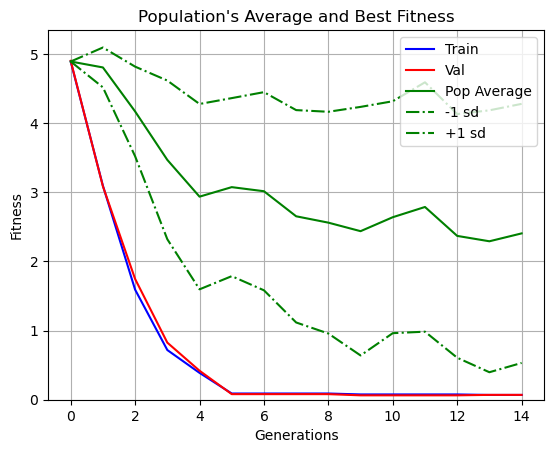

In [44]:
print('RMSE of last validation fold: {}'.format([-winner.fitness, -winner.fitness_val]))

visualize.plot_stats(stats, ylog=False, show_pop=True,  view=True, filename= None)

RMSE: [0.06907878816127777, 0.07006758451461792]


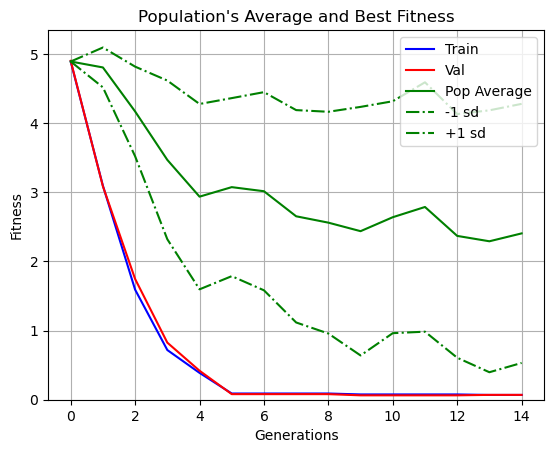

In [45]:
print('RMSE: {}'.format([-winner.fitness, -winner.fitness_val]))

visualize.plot_stats(stats, ylog=False, show_pop=True,  view=True, filename= None)

## Best models of each type and statistical tests

### Best model runs

#### NN Backprop

In [70]:
class DenseNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DenseNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
        self.apply(self._init_weights)
        

    def _init_weights(self, attribute):
        if isinstance(attribute, nn.Linear):
          torch.nn.init.xavier_uniform_(attribute.weight)
          torch.nn.init.zeros_(attribute.bias)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)

        return out

In [71]:
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_tr = torch.tensor(X_tr, dtype=torch.float32)
y_tr = torch.tensor(y_train.values, dtype=torch.float32).reshape(1,-1)[0]
ds_train = TensorDataset(X_tr, y_tr)
dl_train = DataLoader(ds_train, 1, True)

num_epochs = 50
model = DenseNN(12, 8, 1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Training 
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_losses = []
    for inputs, targets in dl_train:
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(1), targets)
        train_losses.append(loss.item())
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {np.mean(train_losses)}')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5, Loss: 0.008454654504860232
Epoch 10, Loss: 0.008233380772621665
Epoch 15, Loss: 0.007389213104072073
Epoch 20, Loss: 0.0063642167698762285
Epoch 25, Loss: 0.006772745191971357
Epoch 30, Loss: 0.006698509426703911
Epoch 35, Loss: 0.005464378506164708
Epoch 40, Loss: 0.005404039501305322
Epoch 45, Loss: 0.005280756502889318
Epoch 50, Loss: 0.0053104454563449146


In [72]:
model.eval()

test_rmse_nn_backprop = []
num_parts = 10
for i in range(num_parts):
    X_i = np.array_split(X_test, num_parts)[i]
    y_i = y_test.loc[X_i.index]
    X_i = scaler.transform(X_i)

    X_i = torch.tensor(X_i, dtype=torch.float32)
    y_i = torch.tensor(y_i.values, dtype=torch.float32).reshape(1,-1)[0]
    ds_i = TensorDataset(X_i, y_i)
    dl_i = DataLoader(ds_i, 1, True)

    with torch.no_grad():
        val_losses = []
        for val_inputs, val_targets in dl_i:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs.squeeze(1), val_targets)
            val_losses.append(val_loss.item())
        avg_val_loss = np.mean(val_losses)
    test_rmse_nn_backprop.append(np.sqrt(avg_val_loss))

/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*ar

In [73]:
np.mean(test_rmse_nn_backprop)

0.05985360123341123

#### NN with Neuroevolution

In [90]:
test_rmse_nn_neuro = []
num_parts = 10

for i in tqdm(range(num_parts)):


    X_val = np.array_split(X_test, num_parts)[i]
    y_val = y_test.loc[X_val.index]

    scaler = MinMaxScaler()
    X_tr = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    X_tr = torch.tensor(X_tr, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)

    y_tr= torch.tensor(y_train.values, dtype=torch.float32).reshape(1,-1)[0]
    y_val = torch.tensor(y_val.values, dtype=torch.float32).reshape(1,-1)[0]

    ds_train = TensorDataset(X_tr, y_tr)
    ds_val = TensorDataset(X_val, y_val)

    total_batches = 1
    batch_size = X_tr.shape[0]
    shuffle = True

    # Creates training and test data loaders
    dl_train = DataLoader(ds_train, batch_size, shuffle)
    dl_val = DataLoader(ds_val, batch_size, shuffle)

    # algorithm specific part

    mutation_prob, xo_prob = prob

    ps = 200
    selection_pressure = .07
    has_elitism = True
    allow_reproduction = False

    sspace_nn = {
            'input_shape': X_tr.shape[1],
            'init_factor': .01,
            'n_hidden_neurons': n_hidden,
            'activation': [torch.relu, torch.relu, None],
            'n_output': 1,
            'n_batches': total_batches,
            'device': device
        }

    pi_sml = SMLNN(
        sspace=sspace_nn,
        ffunction=Ffunctions('rmse'),
        dl_train=dl_train, dl_test=dl_val, 
        n_jobs=8
    )

    mheuristic = GeneticAlgorithm(
        pi=pi_sml,
        initializer=nn_init,
        selector=prm_tournament(pressure=selection_pressure),
        pop_size=ps,
        p_m=mutation_prob,
        p_c=xo_prob,
        elitism=has_elitism,
        reproduction=allow_reproduction, 
        device=device,
        seed=seed,
        crossover=nn_xo,
        mutator=prm_nn_mtn(ms=0.1, sspace=sspace_nn)
    )

    mheuristic._initialize()

    n_iter = 25
    mheuristic.solve(
        n_iter,
        test_elite=True
    )
    
    test_rmse_nn_neuro.append(mheuristic.best_sol.test_fit)

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*ar

In [91]:
test_rmse_nn_neuro

[tensor(0.0601, device='mps:0'),
 tensor(0.0514, device='mps:0'),
 tensor(0.0455, device='mps:0'),
 tensor(0.0351, device='mps:0'),
 tensor(0.0897, device='mps:0'),
 tensor(0.0882, device='mps:0'),
 tensor(0.0511, device='mps:0'),
 tensor(0.0534, device='mps:0'),
 tensor(0.0554, device='mps:0'),
 tensor(0.0347, device='mps:0')]

#### Simple ML

In [22]:
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_tr = torch.tensor(X_tr, dtype=torch.float32)
y_tr = torch.tensor(y_train.values, dtype=torch.float32).reshape(1,-1)[0]
ds_train = TensorDataset(X_tr, y_tr)
dl_train = DataLoader(ds_train, 1, True)

test_rmse_linreg = []
num_parts = 10

for i in range(num_parts):
    X_i = np.array_split(X_test, num_parts)[i]
    y_i = y_test.loc[X_i.index]
    X_i = scaler.transform(X_i)

    lr = LinearRegression()
    lr.fit(X_tr, y_tr)
    test_rmse_linreg.append(mean_squared_error(y_i, lr.predict(X_i))**0.5)


print(f"Average Linreg RMSE: {np.mean(test_rmse_linreg)}")

Average Linreg RMSE: 0.05197230780403141


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*ar

In [23]:
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_tr = torch.tensor(X_tr, dtype=torch.float32)
y_tr = torch.tensor(y_train.values, dtype=torch.float32).reshape(1,-1)[0]
ds_train = TensorDataset(X_tr, y_tr)
dl_train = DataLoader(ds_train, 1, True)

test_rmse_rf = []
num_parts = 10

for i in range(num_parts):
    X_i = np.array_split(X_test, num_parts)[i]
    y_i = y_test.loc[X_i.index]
    X_i = scaler.transform(X_i)

    rf = RandomForestRegressor(n_estimators=200, max_depth=2, random_state=0)
    rf.fit(X_tr, y_tr)
    test_rmse_rf.append(mean_squared_error(y_i, rf.predict(X_i))**0.5)


print(f"Average Linreg RMSE: {np.mean(test_rmse_rf)}")

/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*ar

Average Linreg RMSE: 0.05449547496626528


#### GP

In [59]:
seed = 1
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
shuffle = True
total_batches = 1


test_rmse_gp = []
num_parts = 10
for i in tqdm(range(num_parts)):

    X_val = np.array_split(X_test, num_parts)[i]
    y_val = y_test.loc[X_val.index]

    scaler = MinMaxScaler()
    X_tr = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    X_tr = torch.tensor(X_tr, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)

    y_tr = torch.tensor(y_train.values, dtype=torch.float32).reshape(1,-1)[0]
    y_val = torch.tensor(y_val.values, dtype=torch.float32).reshape(1,-1)[0]

    ds_train = TensorDataset(X_tr, y_tr)
    ds_val = TensorDataset(X_val, y_val)

    total_batches = 1
    batch_size = X_tr.shape[0]
    shuffle = True

    # Creates training and test data loaders
    dl_train = DataLoader(ds_train, X_tr.shape[0], shuffle)
    dl_val = DataLoader(ds_val, X_val.shape[0], shuffle)

    fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div']]

    sspace_1 = {
        'n_dims': X_tr.shape[1],
        'function_set': fset, 'constant_set': ERC(-1., 1.),
        'p_constants': 0.1,
        'max_init_depth': 3,
        'max_depth': 10, 
        'n_batches': total_batches,
        'device': device
    }

    pi_1 = SML(
        sspace=sspace_1,
        ffunction=Ffunctions('rmse'),
        dl_train=dl_train, dl_test=dl_val,  
        n_jobs=1
    )

    ps = 500
    selection_pressure = .07
    mutation_prob = .1
    xo_prob = .9
    has_elitism = True
    allow_reproduction = False

    mheuristic = GeneticAlgorithm(
        pi=pi_1,
        initializer=grow,
        selector = prm_tournament(pressure=0.07),
        crossover=swap_xo,
        mutator=hoist_mtn,
        pop_size=ps,
        p_m=0.1,
        p_c=0.9,
        elitism=has_elitism,
        reproduction=allow_reproduction,  
        device=device,
        seed=seed
    )

    mheuristic._initialize()

    n_iter = 15
    mheuristic.solve(
    n_iter,
    test_elite=True,
    # verbose=True
    )

    test_rmse_gp.append(mheuristic.best_sol.test_fit)

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*ar

In [60]:
test_rmse_gp

[tensor(0.1202, device='mps:0'),
 tensor(0.1074, device='mps:0'),
 tensor(0.1016, device='mps:0'),
 tensor(0.0814, device='mps:0'),
 tensor(0.1396, device='mps:0'),
 tensor(0.1554, device='mps:0'),
 tensor(0.1021, device='mps:0'),
 tensor(0.0982, device='mps:0'),
 tensor(0.0759, device='mps:0'),
 tensor(0.0846, device='mps:0')]

#### GSGP

In [105]:
seed = 1
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
shuffle = True
total_batches = 1


test_rmse_gsgp = []
num_parts = 10
for i in tqdm(range(num_parts)):
    
    X_val = np.array_split(X_test, num_parts)[i]
    y_val = y_test.loc[X_val.index]

    scaler = MinMaxScaler()
    X_tr = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    X_tr = torch.tensor(X_tr, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)

    y_tr = torch.tensor(y_train.values, dtype=torch.float32).reshape(1,-1)[0]
    y_val = torch.tensor(y_val.values, dtype=torch.float32).reshape(1,-1)[0]

    ds_train = TensorDataset(X_tr, y_tr)
    ds_val = TensorDataset(X_val, y_val)

    total_batches = 1
    batch_size = X_tr.shape[0]
    shuffle = True

    # Creates training and test data loaders
    dl_train = DataLoader(ds_train, X_tr.shape[0], shuffle)
    dl_val = DataLoader(ds_val, X_val.shape[0], shuffle)

    fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div']]

    sspace_sml = {
        'n_dims': X_tr.shape[1],
        'function_set': fset, 'constant_set': ERC(-1., 1.),
        'p_constants': 0.1,
        'max_init_depth': 3,
        'max_depth': 10, 
        'n_batches': total_batches,
        'device': device
    }

    pi_sml = SML(
        sspace=sspace_sml,
        ffunction=Ffunctions('rmse'),
        dl_train=dl_train, dl_test=dl_val,
        n_jobs=1
    )

    ps = 250
    selection_pressure = .01
    mutation_prob = .1
    xo_prob = .9
    has_elitism = True
    allow_reproduction = False

    to, by = 5.0, 0.25
    ms = torch.arange(by, to + by, by, device=device)

    mheuristic = GeneticAlgorithm(
        pi=pi_sml,
        initializer=grow,
        selector=double_tournament(pressure=0.07),
        pop_size=ps,
        p_m=mutation_prob,
        p_c=xo_prob,
        elitism=has_elitism,
        reproduction=allow_reproduction,  # False = or xo or mutation
        device=device,
        seed=seed,
        crossover=prm_gs_xo(prm_grow(sspace=pi_sml.sspace), device=device),
        mutator=prm_gs_mtn(prm_grow(sspace=pi_sml.sspace), ms))

    mheuristic._initialize()

    n_iter = 7
    mheuristic.solve(
    n_iter,
    test_elite=True
    )

    test_rmse_gsgp.append(mheuristic.best_sol.test_fit)

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*ar

In [106]:
test_rmse_gsgp

[tensor(0.3082, device='mps:0'),
 tensor(1.3536, device='mps:0'),
 tensor(0.2391, device='mps:0'),
 tensor(1.3126, device='mps:0'),
 tensor(0.3552, device='mps:0'),
 tensor(0.2096, device='mps:0'),
 tensor(0.3432, device='mps:0'),
 tensor(0.4534, device='mps:0'),
 tensor(0.8325, device='mps:0'),
 tensor(0.3083, device='mps:0')]

#### NEAT

In [93]:
def eval_rmse(net, X, y):
    '''
    Auxiliary funciton to evaluate the RMSE.
    '''
    fit = 0.
    for xi, xo in zip(X, y):
        output = net.activate(xi)
        fit += (output[0] - xo)**2
    # RMSE
    return float((fit/y.shape[0])**.5)


def eval_genomes(genomes, config):
    '''
    The function used by NEAT-Python to evaluate the fitness of the genomes.
    -> It has to have the two first arguments equals to the genomes and config objects.
    -> It has to update the `fitness` attribute of the genome.
    '''
    for genome_id, genome in genomes:
        # Define the network
        net = neat.nn.FeedForwardNetwork.create(genome, config)

        # Train fitness

        # Calculate as negative as we inverted problem to maximization for NEAT to work
        # It doesn't work with minimization for some reason
        genome.fitness = -eval_rmse(net, X_tr, y_tr)

        # Validation fitness
        genome.fitness_val = -eval_rmse(net, X_i, y_i)

In [94]:
config_file = 'config-feedforward-xor-full-direct'
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_file)

scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_tr = torch.tensor(X_tr, dtype=torch.float32)
y_tr = torch.tensor(y_train.values, dtype=torch.float32).reshape(1,-1)[0]
ds_train = TensorDataset(X_tr, y_tr)
dl_train = DataLoader(ds_train, 1, True)


test_rmse_neat = []
num_parts = 10
for i in tqdm(range(num_parts)):
    X_i = np.array_split(X_test, num_parts)[i]
    y_i = y_test.loc[X_i.index]
    X_i = scaler.transform(X_i)

    X_i = torch.tensor(X_i, dtype=torch.float32)
    y_i = torch.tensor(y_i.values, dtype=torch.float32).reshape(1,-1)[0]
    ds_i = TensorDataset(X_i, y_i)
    dl_i = DataLoader(ds_i, 1, True)

    p = neat.Population(config)
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)

    winner = p.run(eval_genomes, 15)

    test_rmse_neat.append(-winner.fitness)

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



 ****** Running generation 0 ****** 

Population's average fitness: -4.89358 stdev: 0.00000
Best fitness: -4.89358 - size: (1, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 2.886, standard deviation 1.486
Population of 100 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    66     -4.9    0.000     0
     2    0    29     -4.9    0.000     0
     3    0     2       --       --     0
     4    0     3       --       --     0
Total extinctions: 0
Generation time: 0.325 sec

 ****** Running generation 1 ****** 

Population's average fitness: -4.72850 stdev: 0.47556
Best fitness: -1.38300 - size: (1, 1) - species 2 - id 142
Average adjusted fitness: 0.062
Mean genetic distance 3.461, standard deviation 1.499
Population of 101 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    33     -3.8    0.018     0
     2    1    12   

/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Population's average fitness: -4.89358 stdev: 0.00000
Best fitness: -4.89358 - size: (1, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 2.312, standard deviation 1.437
Population of 100 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    83     -4.9    0.000     0
     2    0    16     -4.9    0.000     0
     3    0     1       --       --     0
Total extinctions: 0
Generation time: 0.277 sec

 ****** Running generation 1 ****** 

Population's average fitness: -4.80867 stdev: 0.26565
Best fitness: -3.46501 - size: (1, 1) - species 1 - id 168
Average adjusted fitness: 0.090
Mean genetic distance 2.805, standard deviation 1.225
Population of 100 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    53     -3.5    0.069     0
     2    1    12     -4.9    0.000     0
     3    1    35     -4.6    0.202     0
Total extinctions

/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Population's average fitness: -4.89358 stdev: 0.00000
Best fitness: -4.89358 - size: (1, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 2.432, standard deviation 1.231
Population of 100 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    29     -4.9    0.000     0
     2    0    61     -4.9    0.000     0
     3    0    10       --       --     0
Total extinctions: 0
Generation time: 0.279 sec

 ****** Running generation 1 ****** 

Population's average fitness: -4.77443 stdev: 0.39624
Best fitness: -2.21690 - size: (1, 1) - species 1 - id 127
Average adjusted fitness: 0.073
Mean genetic distance 3.007, standard deviation 1.202
Population of 100 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    29     -2.2    0.067     0
     2    1    30     -3.5    0.019     0
     3    1    41     -3.9    0.133     0
Total extinctions

/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Population's average fitness: -4.89358 stdev: 0.00000
Best fitness: -4.89358 - size: (1, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 2.397, standard deviation 1.232
Population of 100 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    72     -4.9    0.000     0
     2    0    16     -4.9    0.000     0
     3    0    12       --       --     0
Total extinctions: 0
Generation time: 0.280 sec

 ****** Running generation 1 ****** 

Population's average fitness: -4.82090 stdev: 0.27674
Best fitness: -2.67302 - size: (1, 1) - species 1 - id 175
Average adjusted fitness: 0.019
Mean genetic distance 2.960, standard deviation 1.200
Population of 100 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    73     -2.7    0.043     0
     2    1    10     -4.9    0.000     1
     3    1    17     -4.6    0.016     0
Total extinctions

/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Population's average fitness: -4.89358 stdev: 0.00000
Best fitness: -4.89358 - size: (1, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 2.597, standard deviation 1.614
Population of 100 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    80     -4.9    0.000     0
     2    0    19     -4.9    0.000     0
     3    0     1       --       --     0
Total extinctions: 0
Generation time: 0.280 sec

 ****** Running generation 1 ****** 

Population's average fitness: -4.76010 stdev: 0.40893
Best fitness: -2.30193 - size: (1, 1) - species 2 - id 191
Average adjusted fitness: 0.040
Mean genetic distance 3.149, standard deviation 1.460
Population of 100 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    55     -3.2    0.047     0
     2    1    27     -2.3    0.073     0
     3    1     3     -4.9    0.000     0
     4    0    13

/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Population's average fitness: -4.89358 stdev: 0.00000
Best fitness: -4.89358 - size: (1, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 2.502, standard deviation 1.241
Population of 100 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    53     -4.9    0.000     0
     2    0    34     -4.9    0.000     0
     3    0     8       --       --     0
     4    0     5       --       --     0
Total extinctions: 0
Generation time: 0.281 sec

 ****** Running generation 1 ****** 

Population's average fitness: -4.78146 stdev: 0.36020
Best fitness: -2.75087 - size: (1, 1) - species 1 - id 116
Average adjusted fitness: 0.034
Mean genetic distance 2.990, standard deviation 1.219
Population of 101 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    54     -2.8    0.092     0
     2    1    15     -4.9    0.000     1
     3    1    21

/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Population's average fitness: -4.89358 stdev: 0.00000
Best fitness: -4.89358 - size: (1, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 2.633, standard deviation 1.281
Population of 100 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    39     -4.9    0.000     0
     2    0    48     -4.9    0.000     0
     3    0    13       --       --     0
Total extinctions: 0
Generation time: 0.282 sec

 ****** Running generation 1 ****** 

Population's average fitness: -4.74458 stdev: 0.40106
Best fitness: -2.73422 - size: (1, 1) - species 1 - id 145
Average adjusted fitness: 0.079
Mean genetic distance 3.128, standard deviation 1.211
Population of 100 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    56     -2.7    0.147     0
     2    1    19     -4.8    0.001     0
     3    1    23     -4.0    0.088     0
     4    0     2

/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Population's average fitness: -4.89358 stdev: 0.00000
Best fitness: -4.89358 - size: (1, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 2.727, standard deviation 1.391
Population of 100 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    51     -4.9    0.000     0
     2    0    30     -4.9    0.000     0
     3    0    17       --       --     0
     4    0     2       --       --     0
Total extinctions: 0
Generation time: 0.286 sec

 ****** Running generation 1 ****** 

Population's average fitness: -4.73761 stdev: 0.39996
Best fitness: -2.53811 - size: (1, 1) - species 2 - id 128
Average adjusted fitness: 0.067
Mean genetic distance 3.299, standard deviation 1.294
Population of 99 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1     6     -4.2    0.017     0
     2    1    24     -2.5    0.115     0
     3    1    67 

/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Population's average fitness: -4.89358 stdev: 0.00000
Best fitness: -4.89358 - size: (1, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 2.355, standard deviation 1.146
Population of 100 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    60     -4.9    0.000     0
     2    0    30     -4.9    0.000     0
     3    0    10       --       --     0
Total extinctions: 0
Generation time: 0.303 sec

 ****** Running generation 1 ****** 

Population's average fitness: -4.80302 stdev: 0.28398
Best fitness: -3.40633 - size: (1, 1) - species 1 - id 125
Average adjusted fitness: 0.052
Mean genetic distance 2.915, standard deviation 1.097
Population of 100 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    53     -3.4    0.090     0
     2    1    23     -4.8    0.002     0
     3    1    24     -4.1    0.065     0
Total extinctions

/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Population's average fitness: -4.89358 stdev: 0.00000
Best fitness: -4.89358 - size: (1, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 2.024, standard deviation 1.139
Population of 100 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    88     -4.9    0.000     0
     2    0     7       --       --     0
     3    0     5       --       --     0
Total extinctions: 0
Generation time: 0.303 sec

 ****** Running generation 1 ****** 

Population's average fitness: -4.85193 stdev: 0.17713
Best fitness: -3.70151 - size: (1, 1) - species 1 - id 133
Average adjusted fitness: 0.015
Mean genetic distance 3.004, standard deviation 1.211
Population of 100 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    53     -3.7    0.039     0
     2    1    24     -4.8    0.006     0
     3    1    19     -4.9    0.000     0
     4    0     4

### Statistical tests and comparison

In [123]:
data_dict = {'NN_backprop' : torch.tensor(test_rmse_nn_backprop).cpu(), 
        'NN_Neuro' : torch.tensor(test_rmse_nn_neuro).cpu(), 
        'GSGP' : torch.tensor(test_rmse_gsgp).cpu(), 
        'GP' : torch.tensor(test_rmse_gp).cpu(), 
        'LinReg' : torch.tensor(test_rmse_linreg).cpu(), 
        'RF' : torch.tensor(test_rmse_rf).cpu(), 
        'NEAT' : torch.tensor(test_rmse_neat).cpu()}

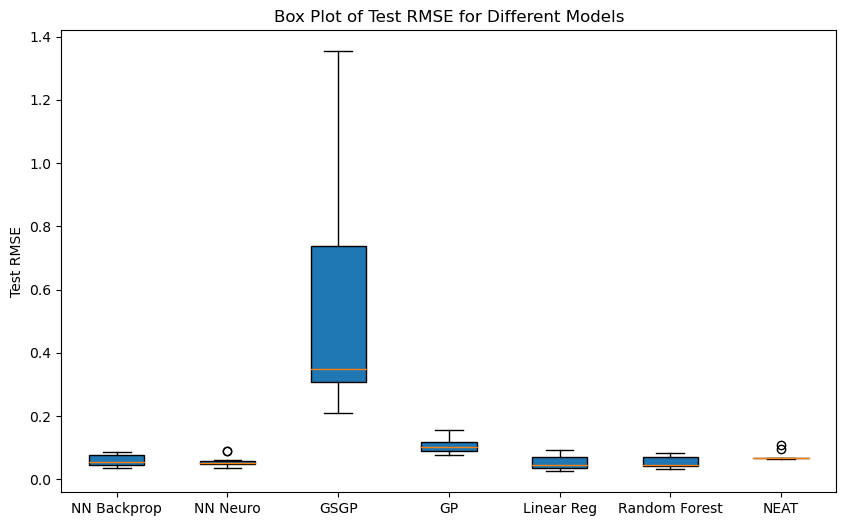

In [124]:
# All models

data = [torch.tensor(test_rmse_nn_backprop).cpu(), 
        torch.tensor(test_rmse_nn_neuro).cpu(), 
        torch.tensor(test_rmse_gsgp).cpu(), 
        torch.tensor(test_rmse_gp).cpu(), 
        torch.tensor(test_rmse_linreg).cpu(), 
        torch.tensor(test_rmse_rf).cpu(), 
        torch.tensor(test_rmse_neat).cpu()]

labels = ['NN Backprop', 'NN Neuro',
          'GSGP', 
          'GP', 'Linear Reg', 'Random Forest', 'NEAT']

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels, patch_artist=True)


plt.title('Box Plot of Test RMSE for Different Models')
plt.ylabel('Test RMSE')

plt.show()

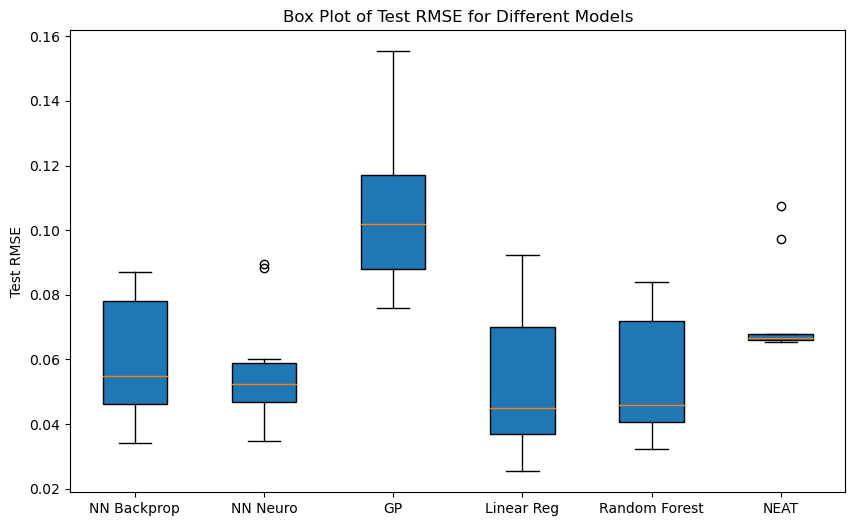

In [158]:
# All models

data = [torch.tensor(test_rmse_nn_backprop).cpu(), 
        torch.tensor(test_rmse_nn_neuro).cpu(), 
        torch.tensor(test_rmse_gp).cpu(), 
        torch.tensor(test_rmse_linreg).cpu(), 
        torch.tensor(test_rmse_rf).cpu(), 
        torch.tensor(test_rmse_neat).cpu()]

labels = ['NN Backprop', 'NN Neuro',
          'GP', 'Linear Reg', 'Random Forest', 'NEAT']

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels, patch_artist=True)


plt.title('Box Plot of Test RMSE for Different Models')
plt.ylabel('Test RMSE')

plt.show()

In [155]:
combinations = list(itertools.combinations(data_dict.keys(), 2))
for i in combinations:

    stat, p_value = wilcoxon(data_dict[i[0]], data_dict[i[1]])

    print(f'Test for RMSE equality between: {i[0]} and {i[1]}')
    print(i[0], " mean RMSE: ", np.round(np.mean(data_dict[i[0]].numpy()), 3), ',', i[1], " mean RMSE: " , np.round(np.mean(data_dict[i[1]].numpy()), 3))
    print(f'Statistic: {stat}, p-value: {np.round(p_value,4)}')
    if p_value < 0.05:
        print('Difference in RMSE means is statistically significant')
    else:
        print('Difference in RMSE means is not statistically significant')
    print('\n')

Test for RMSE equality between: NN_backprop and NN_Neuro
NN_backprop  mean RMSE:  0.06 , NN_Neuro  mean RMSE:  0.056
Statistic: 20.0, p-value: 0.4922
Difference in RMSE means is not statistically significant


Test for RMSE equality between: NN_backprop and GSGP
NN_backprop  mean RMSE:  0.06 , GSGP  mean RMSE:  0.572
Statistic: 0.0, p-value: 0.002
Difference in RMSE means is statistically significant


Test for RMSE equality between: NN_backprop and GP
NN_backprop  mean RMSE:  0.06 , GP  mean RMSE:  0.107
Statistic: 0.0, p-value: 0.002
Difference in RMSE means is statistically significant


Test for RMSE equality between: NN_backprop and LinReg
NN_backprop  mean RMSE:  0.06 , LinReg  mean RMSE:  0.052
Statistic: 2.0, p-value: 0.0059
Difference in RMSE means is statistically significant


Test for RMSE equality between: NN_backprop and RF
NN_backprop  mean RMSE:  0.06 , RF  mean RMSE:  0.054
Statistic: 0.0, p-value: 0.002
Difference in RMSE means is statistically significant


Test for 

### List of implemented exercises

<hr />

##### **Exercise 1.a - Done**
**Implement the full and the ramped half-n-half initializers.**

\>> *The rhh initialization implementation will be evaluated in the final project. Its solution will be provided before the project delivery, so it is a basic implementation exercise.*


<hr />

<br />

<hr />

##### **Exercise 1.b - Done**
**Implement the Hoist mutation.**

\>> *The hoist mutation implementation will be evaluated in the final project. Its solution will be provided before the project delivery, so it is a basic implementation exercise.*


<hr />

<br />

<hr />

##### **Exercise 2 - Done**
**Implement the double tournament selection algorithm.**

\>> *The Double tournament selection algorithm implementation will be evaluated in the final project. Its solution will be provided only after the project delivery, so it is an advanced implementation exercise.*

Double Tournament selection algorithm

It performs two sequential tournament selections, one for each objective, e.g., RMSE and tree size.

<hr />

<br />

<hr />

##### **Exercise 1  - Done**
**Implement the Geometric Semantic Crossover and Mutation proposed by Moraglio et al. 2012.**

\>> *The GSXO and GSM implementation will be evaluated in the final project. Its solution will be provided before the project delivery, so it is a basic implementation exercise.*


<hr />

<br />

<hr />

##### **Exercise 2  - Done**
**Implement the Efficient Geometric Semantic Crossover and Mutation proposed by Vanneschi et al. 2013.**

\>> *The Efficient GSXO and GSM implementation will be evaluated in the final project. Its solution will be provided before the project delivery, so it is a basic implementation exercise.*


<hr />

<br />

<br />

> ##### **Exercise for extra points** - Done
**Implement a crossover and a mutation operators for evolving the weights and bias of a Neural Network.**

<br />